### Amazon Reviews for Sentiment Analysis

Obiettivo: costruire una rete neurale che riesca a capire se una recensione è negativa o positiva

In [9]:
import pandas as pd
from keras.layers import GlobalMaxPooling1D
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras import models, layers, optimizers
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
import bz2
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import re
from keras.models import Sequential
from keras.callbacks import LambdaCallback
from keras.layers import Dense, LSTM
import seaborn as sns

Leggiamo il file e creiamo due liste una con le label e l'altra per le recensioni, sia per il training sia per il test

In [2]:
train_file = bz2.BZ2File('train.ft.txt.bz2')
test_file = bz2.BZ2File('test.ft.txt.bz2')

In [3]:
train_lines = train_file.readlines()
test_lines = test_file.readlines()

In [4]:
train_file_lines = [x.decode('utf-8') for x in train_lines]
test_file_lines = [x.decode('utf-8') for x in test_lines]

In [5]:
train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train_file_lines]
train_sentences = [x.split(' ', 1)[1][:-1].lower() for x in train_file_lines]

In [6]:
test_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in test_file_lines]
test_sentences = [x.split(' ', 1)[1][:-1].lower() for x in test_file_lines]

In [7]:
train_sentences[1]

"the best soundtrack ever to anything.: i'm reading a lot of reviews saying that this is the best 'game soundtrack' and i figured that i'd write a review to disagree a bit. this in my opinino is yasunori mitsuda's ultimate masterpiece. the music is timeless and i'm been listening to it for years now and its beauty simply refuses to fade.the price tag on this is pretty staggering i must say, but if you are going to buy any cd for this much money, this is the only one that i feel would be worth every penny."

Vediamo se il dataset è bilanciato (sia train che test set)

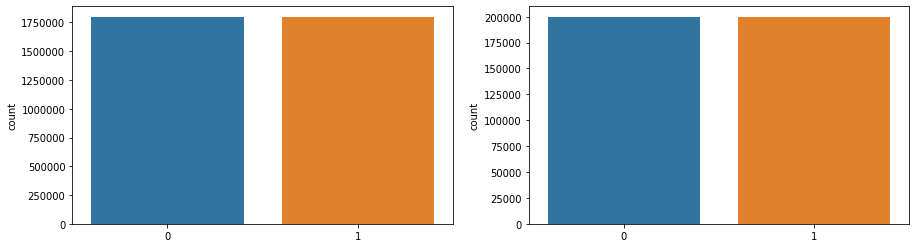

In [10]:
fig, axes = plt.subplots(1,2, figsize=(15,4))
sns.countplot(train_labels, ax=axes[0])
sns.countplot(test_labels, ax=axes[1])
plt.show()

Trasformiamo il testo tutto in lower case ed effettuiamo alcune operazioni di pulizia del testo

In [11]:

import re

no_punt= re.compile(r'[\W]')
no_num= re.compile(r'[^a-z-\s]')
def normalize_texts(texts):
    normalized_texts = []
    for text in texts:
        lower = text.lower()
        no_punctuation = no_punt.sub(r' ', lower)
        no_numer = no_num.sub(r' ', no_punctuation)
        normalized_texts.append(no_numer)
    
    return normalized_texts
        
train = normalize_texts(train_sentences)
test = normalize_texts(test_sentences)

In [14]:
train[4]

'remember  pull your jaw off the floor after hearing it  if you ve played the game  you know how divine the music is  every single song tells a story of the game  it s that good  the greatest songs are without a doubt  chrono cross  time s scar  magical dreamers  the wind  the stars  and the sea and radical dreamers  unstolen jewel   translation varies  this music is perfect if you ask me  the best it can be  yasunori mitsuda just poured his heart on and wrote it down on paper '

In [15]:
train[1]

'the best soundtrack ever to anything   i m reading a lot of reviews saying that this is the best  game soundtrack  and i figured that i d write a review to disagree a bit  this in my opinino is yasunori mitsuda s ultimate masterpiece  the music is timeless and i m been listening to it for years now and its beauty simply refuses to fade the price tag on this is pretty staggering i must say  but if you are going to buy any cd for this much money  this is the only one that i feel would be worth every penny '

Riserviamo il 20% del training per la parte di validation

In [12]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train, train_labels, test_size=0.2)

Trasformiamo il testo in token e indiciziamo le parole con la Tokenizer API di Keras

In [13]:

tokenizer = Tokenizer(num_words=30000)
tokenizer.fit_on_texts(train_texts)
train_texts = tokenizer.texts_to_sequences(train_texts)
val_texts = tokenizer.texts_to_sequences(val_texts)
test_texts = tokenizer.texts_to_sequences(test)



In [18]:
train_texts[1]

[11223, 8290, 12306, 1551, 2765, 1627]

Vediamo la lunghezza del dizionario e la lunghezza delle recesioni

In [14]:
len(tokenizer.word_index)

763736

In [15]:
review_length = [len(train_texts[i]) for i in range(len(train_texts))]

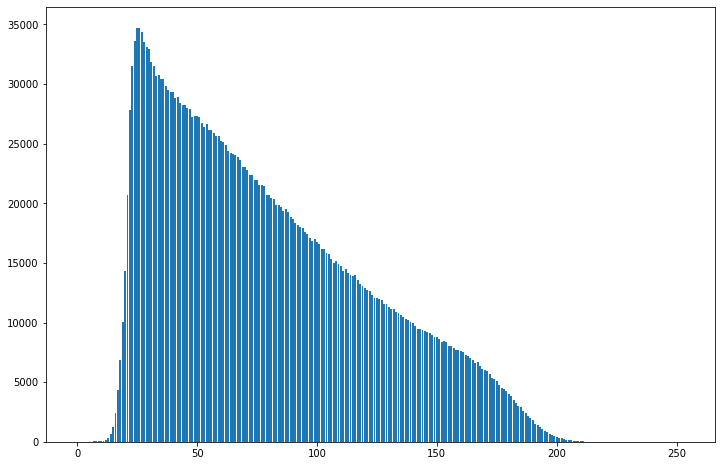

In [16]:
from collections import Counter

c = Counter(review_length)

plt.figure(figsize=(12,8))
plt.bar(c.keys(), c.values())
plt.show()

In [17]:
max(c.keys())

253

Dopo alcune prove abbiamo scelto con dimensione massima del dizionario che vogliamo usare 30000.
La recensione più lunga nel traingin set risulta essere 253: osservando il grafico e rimuovendo gli outlier che sono più lunghi settiamo il valore maxlen a 230. Inseriamo il padding per uniformare le lunghezze delle review.

In [27]:
max_review_length = 230
MAX_FEATURES = 30000


In [28]:
from keras.preprocessing import sequence

x_train = sequence.pad_sequences(train_texts, maxlen=max_review_length)
x_test = sequence.pad_sequences(test_texts, maxlen=max_review_length)
val_texts = pad_sequences(val_texts, maxlen=max_review_length)

In [21]:
x_test[1]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,    26,     7,
           1,    88,   145,   118,  6654,    11,     4,   145,     2,
         143,    21,    65,   234,  1047,     1,   340,    12,     2,
          22,    60,   525,     4,   246,  2637,     7,     1,   145,
           1,   118,     2,   313,   617,     1,  1319,     5, 21105,
        4807,    91,    14,    31,    24,    68,  1676,    46,     5,
         275,     1,

Addestriamo la prima rete: utilizziamo il layer di Embedding di keras con i pesi inizializzati random e scelti dalla rete durante il traing.

In [89]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.embeddings import Embedding
from keras.layers import Flatten, Dropout, Bidirectional
from keras.callbacks import EarlyStopping
from keras import optimizers


embedding_vector_length = 32
model = Sequential()
model.add(Embedding(MAX_FEATURES, embedding_vector_length , input_length=max_review_length))
model.add(Flatten())

model.add(Dense(20, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(20, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(20, activation='relu'))

model.add(Dropout(0.25))

model.add(Dense(1, activation='sigmoid'))

early_stopping = EarlyStopping(monitor='val_loss', patience=2)
model.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(lr=0.0001), metrics=["accuracy"])
    
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 230, 32)           960000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 7360)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 20)                147220    
_________________________________________________________________
dropout_6 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 20)                420       
_________________________________________________________________
dropout_7 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 20)               

In [90]:
hist = model.fit(x_train,  train_labels, validation_data=(val_texts, val_labels), epochs=100, batch_size=500,callbacks=[early_stopping])


C:\Users\calca\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2880000 samples, validate on 720000 samples
Epoch 1/100
2880000/2880000 [==============================] - 262s 91us/step - loss: 0.2980 - accuracy: 0.8746 - val_loss: 0.2203 - val_accuracy: 0.9129
Epoch 2/100
2880000/2880000 [==============================] - 258s 90us/step - loss: 0.2254 - accuracy: 0.9146 - val_loss: 0.2141 - val_accuracy: 0.9154
Epoch 3/100
2880000/2880000 [==============================] - 251s 87us/step - loss: 0.2137 - accuracy: 0.9189 - val_loss: 0.2087 - val_accuracy: 0.9177
Epoch 4/100
2880000/2880000 [==============================] - 250s 87us/step - loss: 0.2054 - accuracy: 0.9225 - val_loss: 0.2061 - val_accuracy: 0.9190
Epoch 5/100
2880000/2880000 [==============================] - 251s 87us/step - loss: 0.1984 - accuracy: 0.9256 - val_loss: 0.2058 - val_accuracy: 0.9198
Epoch 6/100
2880000/2880000 [==============================] - 251s 87us/step - loss: 0.1914 - accuracy: 0.9284 - val_loss: 0.2052 - val_accuracy: 0.9201
Epoch 7/100
2880000/288

Vediamo graficamente il confronto tra training set e validation set per accuracy e loss.

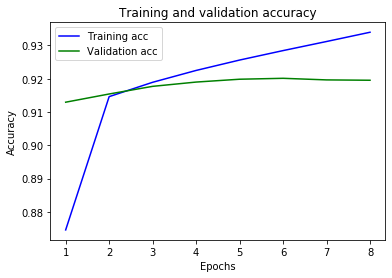

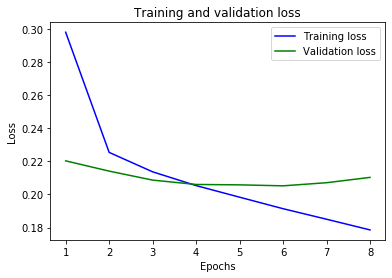

In [91]:
import matplotlib.pyplot as plt

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title('Training and validation accuracy')
plt.legend()
fig = plt.figure()
#fig.savefig('acc.png')


plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

In [92]:
#valutiamo il primo modello
score = model.evaluate(x_test, test_labels, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

400000/400000 [==============================] - 17s 44us/step
Test Score: 0.21283608397632836
Test Accuracy: 0.9183124899864197


In [93]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

y_pred = model.predict(x_test).flatten()
y_pred = np.round(y_pred)

# compute confusion matrix
print ("Confusion Matrix")
print ( confusion_matrix(test_labels, y_pred))

# compute classification report
print ("Classification Report")
print ( classification_report(test_labels, y_pred))

Confusion Matrix
[[182716  17284]
 [ 15391 184609]]
Classification Report
              precision    recall  f1-score   support

           0       0.92      0.91      0.92    200000
           1       0.91      0.92      0.92    200000

    accuracy                           0.92    400000
   macro avg       0.92      0.92      0.92    400000
weighted avg       0.92      0.92      0.92    400000



Addestriamo ora una RNN di tipo LSTM

In [80]:
from keras.layers.embeddings import Embedding
model = Sequential()

embedding_vector_length = 32
model.add(Embedding(MAX_FEATURES, embedding_vector_length , input_length=max_review_length))
 
model.add(LSTM(6))
model.add(Dropout(0.25))
model.add(Dense(6, activation='relu'))

model.add(Dropout(0.25))
          
model.add(Dense(1,activation='sigmoid'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model.compile(loss='binary_crossentropy',optimizer=optimizers.rmsprop(lr=0.0001), metrics=['accuracy'])


hist = model.fit(x_train,  train_labels, validation_data=(val_texts, val_labels), epochs=100, batch_size=500,callbacks=[early_stopping])

C:\Users\calca\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2880000 samples, validate on 720000 samples
Epoch 1/100
2880000/2880000 [==============================] - 1099s 382us/step - loss: 0.4120 - accuracy: 0.8451 - val_loss: 0.2267 - val_accuracy: 0.9138
Epoch 2/100
2880000/2880000 [==============================] - 1080s 375us/step - loss: 0.2483 - accuracy: 0.9133 - val_loss: 0.2050 - val_accuracy: 0.9199
Epoch 3/100
2880000/2880000 [==============================] - 926s 321us/step - loss: 0.2328 - accuracy: 0.9183 - val_loss: 0.1966 - val_accuracy: 0.9244
Epoch 4/100
2880000/2880000 [==============================] - 913s 317us/step - loss: 0.2235 - accuracy: 0.9219 - val_loss: 0.1884 - val_accuracy: 0.9284
Epoch 5/100
2880000/2880000 [==============================] - 913s 317us/step - loss: 0.2139 - accuracy: 0.9259 - val_loss: 0.1802 - val_accuracy: 0.9329
Epoch 6/100
2880000/2880000 [==============================] - 923s 320us/step - loss: 0.2049 - accuracy: 0.9297 - val_loss: 0.1732 - val_accuracy: 0.9355
Epoch 7/100
288

In [81]:
#valutazione
score = model.evaluate(x_test, test_labels, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

400000/400000 [==============================] - 216s 540us/step
Test Score: 0.1525166356967017
Test Accuracy: 0.9443075060844421


In [82]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

y_pred = model.predict(x_test).flatten()
y_pred = np.round(y_pred)

# compute confusion matrix
print ("Confusion Matrix")
print ( confusion_matrix(test_labels, y_pred))

# compute classification report
print ("Classification Report")
print ( classification_report(test_labels, y_pred))

Confusion Matrix
[[190397   9603]
 [ 12674 187326]]
Classification Report
              precision    recall  f1-score   support

           0       0.94      0.95      0.94    200000
           1       0.95      0.94      0.94    200000

    accuracy                           0.94    400000
   macro avg       0.94      0.94      0.94    400000
weighted avg       0.94      0.94      0.94    400000



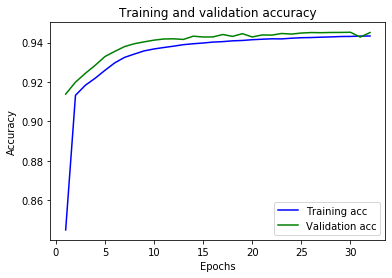

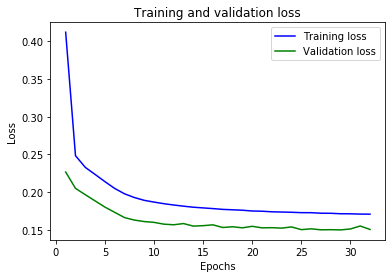

In [83]:
import matplotlib.pyplot as plt

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title('Training and validation accuracy')
plt.legend()
fig = plt.figure()
#fig.savefig('acc.png')


plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

Addestriamo ora una rete convoluzionale con un layer convoluzionale di tipo 1D.

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling1D, Flatten, Conv1D, Dropout

# initialize the network
embedding_vector_length = 32

model= Sequential()
model.add(Embedding(MAX_FEATURES, embedding_vector_length, input_length=max_review_length))



model.add(Conv1D(filters=20, kernel_size=3,
                 padding='valid',
                 activation='relu'))


model.add(MaxPooling1D())
model.add(Flatten())       
model.add(Dropout(0.25))
model.add(Dense(24, activation='relu'))

model.add(Dropout(0.25))
          

# finalize the network
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=optimizers.rmsprop(lr=0.0001), metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2)
# train the network
hist = model.fit(x_train,  train_labels, validation_data=(val_texts, val_labels), epochs=100, batch_size=500,callbacks=[early_stopping])

C:\Users\calca\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2880000 samples, validate on 720000 samples
Epoch 1/100
2880000/2880000 [==============================] - 729s 253us/step - loss: 0.2895 - accuracy: 0.8746 - val_loss: 0.2073 - val_accuracy: 0.9191
Epoch 2/100
2880000/2880000 [==============================] - 701s 244us/step - loss: 0.2040 - accuracy: 0.9223 - val_loss: 0.1880 - val_accuracy: 0.9282
Epoch 3/100
2880000/2880000 [==============================] - 684s 237us/step - loss: 0.1880 - accuracy: 0.9295 - val_loss: 0.1758 - val_accuracy: 0.9334
Epoch 4/100
2880000/2880000 [==============================] - 636s 221us/step - loss: 0.1789 - accuracy: 0.9335 - val_loss: 0.1693 - val_accuracy: 0.9362
Epoch 5/100
2880000/2880000 [==============================] - 634s 220us/step - loss: 0.1728 - accuracy: 0.9362 - val_loss: 0.1648 - val_accuracy: 0.9381
Epoch 6/100
2880000/2880000 [==============================] - 635s 220us/step - loss: 0.1683 - accuracy: 0.9382 - val_loss: 0.1625 - val_accuracy: 0.9392
Epoch 7/100
28800

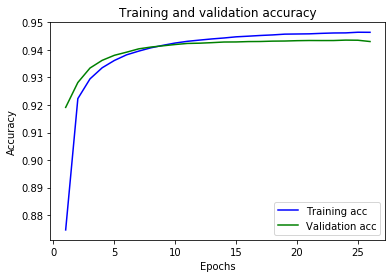

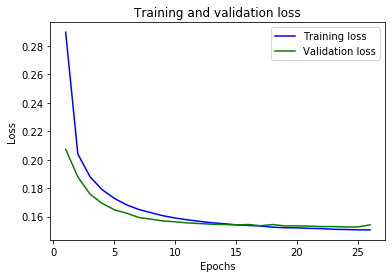

In [30]:
import matplotlib.pyplot as plt

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title('Training and validation accuracy')
plt.legend()
fig = plt.figure()
#fig.savefig('acc.png')


plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

In [31]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

y_pred = model.predict(x_test).flatten()
y_pred = np.round(y_pred)

# compute confusion matrix
print ("Confusion Matrix")
print ( confusion_matrix(test_labels, y_pred) )

# compute classification report
print ("Classification Report")
print ( classification_report(test_labels, y_pred) )

Confusion Matrix
[[190662   9338]
 [ 13406 186594]]
Classification Report
              precision    recall  f1-score   support

           0       0.93      0.95      0.94    200000
           1       0.95      0.93      0.94    200000

    accuracy                           0.94    400000
   macro avg       0.94      0.94      0.94    400000
weighted avg       0.94      0.94      0.94    400000



In [32]:
score = model.evaluate(x_test, test_labels, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

400000/400000 [==============================] - 38s 95us/step
Test Score: 0.15501950088649988
Test Accuracy: 0.9431399703025818


#### Pre-trained word embedding

Riportiamo qui gli step fatti per fare il training della rete con pre-trained word embedding nell'embedding layer

Costruiamo un medello word2vec con le recensioni

In [18]:
from gensim.models import Word2Vec
from nltk import word_tokenize

In [ ]:
tok_sents = [word_tokenize(text) for text in train_texts[:100000]]

w2v_model = Word2Vec(tok_sents, size=300, window=10, min_count=5, sg=1, iter=20, negative=10)
w2v_model.wv.save_word2vec_format('reviews_embedding_word2vec_100k.txt')

Costruiamo ora l'embedding index e l'embedding matrix da passare all'embedding layer

In [19]:
embedding_index = {}
with open('reviews_embedding_word2vec_100k.txt', encoding = 'utf-8') as input_handle:
    line = input_handle.readline()
    while True:
        line = input_handle.readline()    
        if line == "":
            break
        values = line.split()
        word = values[0]
        coef = np.asarray(values[1:])
        embedding_index[word] = coef

In [20]:
embedding_vector_length = 300
word_index = tokenizer.word_index
num_word = 30000

embedding_matix = np.zeros((num_word, embedding_vector_length))

for word, i in word_index.items():
    if i > num_word:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matix[i] = embedding_vector

Riportiamo qui la rete allenata usando questo embedding con un solo livello denso (è stata testata con la stessa configuazione usata sopra (3 livelli hidden densi) e ottenuto in ogni caso risultati peggiori rispetto alla rete con embedding layer con pesi default).

In [25]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.embeddings import Embedding
from keras.layers import Flatten, Dropout, Bidirectional
from keras.initializers import Constant
from keras.callbacks import EarlyStopping
from keras import optimizers


max_review_length = 230
MAX_FEATURES = 30000
embedding_vector_length = 300

model = Sequential()
embedding_layer = Embedding(MAX_FEATURES, 
                            embedding_vector_length,
                            embeddings_initializer= Constant(embedding_matix),
                            input_length=max_review_length,
                            trainable=False)
model.add(embedding_layer)
model.add(Flatten())

model.add(Dense(50, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(1, activation='sigmoid'))
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 230, 300)          9000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 69000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                3450050   
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 12,450,101
Trainable params: 3,450,101
Non-trainable params: 9,000,000
_________________________________________________________________
None


In [29]:
hist = model.fit(x_train,  train_labels, validation_data=(val_texts, val_labels), epochs=100, batch_size=500,callbacks=[early_stopping])

Train on 2880000 samples, validate on 720000 samples
Epoch 1/100
2880000/2880000 [==============================] - 1628s 565us/step - loss: 0.3090 - accuracy: 0.8686 - val_loss: 0.2812 - val_accuracy: 0.8808
Epoch 2/100
2880000/2880000 [==============================] - 1495s 519us/step - loss: 0.2703 - accuracy: 0.8874 - val_loss: 0.2708 - val_accuracy: 0.8868
Epoch 3/100
2880000/2880000 [==============================] - 1377s 478us/step - loss: 0.2492 - accuracy: 0.8979 - val_loss: 0.2661 - val_accuracy: 0.8899
Epoch 4/100
2880000/2880000 [==============================] - 1380s 479us/step - loss: 0.2299 - accuracy: 0.9077 - val_loss: 0.2669 - val_accuracy: 0.8904
Epoch 5/100
2880000/2880000 [==============================] - 1378s 479us/step - loss: 0.2123 - accuracy: 0.9160 - val_loss: 0.2706 - val_accuracy: 0.8916


Costruiamo ora l'embedding index e l'embedding matrix da passare all'embedding layer usando il pre-trained embedding GloVe.

In [30]:
embeddings_dictionary = dict()
glove_file = open('./glove.6B.300d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [31]:
embedding_vector_length = 300
word_index = tokenizer.word_index
num_word = 30000

embedding_matix = np.zeros((num_word, embedding_vector_length))

for word, i in word_index.items():
    if i > num_word-1:
        continue
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matix[i] = embedding_vector

Riportiamo qui la rete allenata usando questo embedding con un solo livello denso (è stata testata con la stessa configuazione usata sopra (3 livelli hidden densi) e ottenuto in ogni caso risultati peggiori rispetto alla rete con embedding layer con pesi default).

In [32]:
max_review_length = 230
MAX_FEATURES = 30000
embedding_vector_length = 300

model = Sequential()
embedding_layer = Embedding(MAX_FEATURES, 
                            embedding_vector_length,
                            embeddings_initializer= Constant(embedding_matix),
                            input_length=max_review_length,
                            trainable=False)
model.add(embedding_layer)
model.add(Flatten())

model.add(Dense(50, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(1, activation='sigmoid'))
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=['accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 230, 300)          9000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 69000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                3450050   
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 12,450,101
Trainable params: 3,450,101
Non-trainable params: 9,000,000
_________________________________________________________________
None


In [33]:
hist = model.fit(x_train,  train_labels, validation_data=(val_texts, val_labels), epochs=100, batch_size=500,callbacks=[early_stopping])

Train on 2880000 samples, validate on 720000 samples
Epoch 1/100
2880000/2880000 [==============================] - 1616s 561us/step - loss: 0.3795 - accuracy: 0.8301 - val_loss: 0.3491 - val_accuracy: 0.8462
Epoch 2/100
2880000/2880000 [==============================] - 1451s 504us/step - loss: 0.3353 - accuracy: 0.8543 - val_loss: 0.3300 - val_accuracy: 0.8568
Epoch 3/100
2880000/2880000 [==============================] - 1395s 484us/step - loss: 0.3120 - accuracy: 0.8665 - val_loss: 0.3228 - val_accuracy: 0.8611
Epoch 4/100
2880000/2880000 [==============================] - 1454s 505us/step - loss: 0.2927 - accuracy: 0.8764 - val_loss: 0.3181 - val_accuracy: 0.8638
Epoch 5/100
2880000/2880000 [==============================] - 1388s 482us/step - loss: 0.2760 - accuracy: 0.8844 - val_loss: 0.3164 - val_accuracy: 0.8653
Epoch 6/100
2880000/2880000 [==============================] - 1392s 483us/step - loss: 0.2616 - accuracy: 0.8909 - val_loss: 0.3225 - val_accuracy: 0.8661
Epoch 7/100